## Description

In this competition, participants will work with four datasets: training, validation, test, and comp_test. The training dataset contains labeled data that competitors will use to train their models. The validation dataset allows them to fine-tune their models and assess performance during development. The test dataset provides an additional benchmark to estimate how well their models generalize to unseen data. However, the comp_test dataset is different—it consists of unlabeled data for which participants must generate predictions. Their final task is to submit predictions for this dataset, which will be evaluated against hidden ground-truth labels to determine the competition rankings.

In [77]:
# Import deep learning libraries
import os #para que funcione bien en windows, linux y mac
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset,Dataset
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt # Añadido para visualización
from tqdm import tqdm

# **Paso 1: Separacion de datos y preprocesamiento** 

## Pipeline de Preprocesamiento de Imágenes

La canalización de transformación está diseñada para preprocesar las imágenes antes de alimentarlas al modelo, siguiendo los requisitos de la competencia. Los pasos involucrados son:

1. **Convertir a escala de grises**:  
   `transforms.Grayscale(num_output_channels=1)` asegura que todas las imágenes tengan un solo canal, reduciendo la complejidad y enfocándose en las características estructurales.

2. **Redimensionar a una dimensión fija**:  
   `transforms.Resize((150, 150))` ajusta todas las imágenes a un tamaño estándar de **150x150 píxeles**, tal como lo requiere la línea base de la competencia.

3. **Convertir a Tensor**:  
   `transforms.ToTensor()` convierte las imágenes en **tensores de PyTorch**, normalizando los valores de los píxeles al rango $[0, 1]$.

4. **Normalizar valores de píxeles**:  
   `transforms.Normalize(mean=[0.5], std=[0.5])` estandariza los valores de los píxeles para que tengan una **media de cero** y un rango aproximadamente de $[-1, 1]$, estabilizando el proceso de entrenamiento.

Este preprocesamiento garantiza la uniformidad en los conjuntos de datos de **entrenamiento (train)**, **validación (val)**, **prueba (test)** y el set ciego de la competencia (**comp_test**).

In [78]:
# Transformaciones para ENTRENAMIENTO (con aumentación)
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(p=0.5), # Voltea la imagen
    transforms.RandomRotation(15),          # Rota hasta 15 grados
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Transformaciones para VALIDACIÓN/TEST (sin aumentación, solo formato)
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

## Preparación del Dataset de Entrenamiento

1. **Ruta**: Se utiliza el directorio local `data/seg_train` con imágenes organizadas por carpetas de clase.
2. **Carga**: `datasets.ImageFolder` automatiza el etiquetado y aplica las transformaciones de preprocesamiento.
3. **Batch Size**: Se define un tamaño de lote de `32` para procesar imágenes en grupos durante el entrenamiento.
4. **DataLoader**: `DataLoader(shuffle=True)` crea un iterable que mezcla los datos en cada época para mejorar la generalización y evitar el sobreajuste.

In [79]:
# train dataset local
base_path = 'data'
train_path = os.path.join(base_path, 'seg_train')

# Cargamos usando ImageFolder
train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)

# Define batch size
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Verificación inicial
for images, labels in train_loader:
    print(f"Dimensiones del batch: {images.shape}") # Debe ser [32, 1, 150, 150]
    print(f"Etiquetas del batch: {labels.shape}")
    break

Dimensiones del batch: torch.Size([32, 1, 150, 150])
Etiquetas del batch: torch.Size([32])


## Visualización de Imágenes del Dataset de Entrenamiento

Este bloque recupera un lote de imágenes del `train_loader`, las desnormaliza y las grafica para inspeccionar visualmente los datos.

1. **Iteración**: Se extrae un lote de `images` y `labels` del cargador de datos.
2. **Desnormalización**: Se revierte la normalización (`images * 0.5 + 0.5`) para devolver los píxeles al rango original $[0,1]$ y visualizarlos correctamente.
3. **Graficación**: 
   - Se crea una cuadrícula de 3x3 para mostrar las primeras 9 imágenes.
   - Se usa `cmap='gray'` para representar correctamente el canal único de gris.
   - Se asigna el título con la etiqueta correspondiente y se ocultan los ejes.
4. **Finalización**: Se utiliza `break` para procesar únicamente el primer lote.

Esta visualización permite verificar que el preprocesamiento (escala de grises y redimensionamiento) se aplicó correctamente antes de iniciar el entrenamiento.

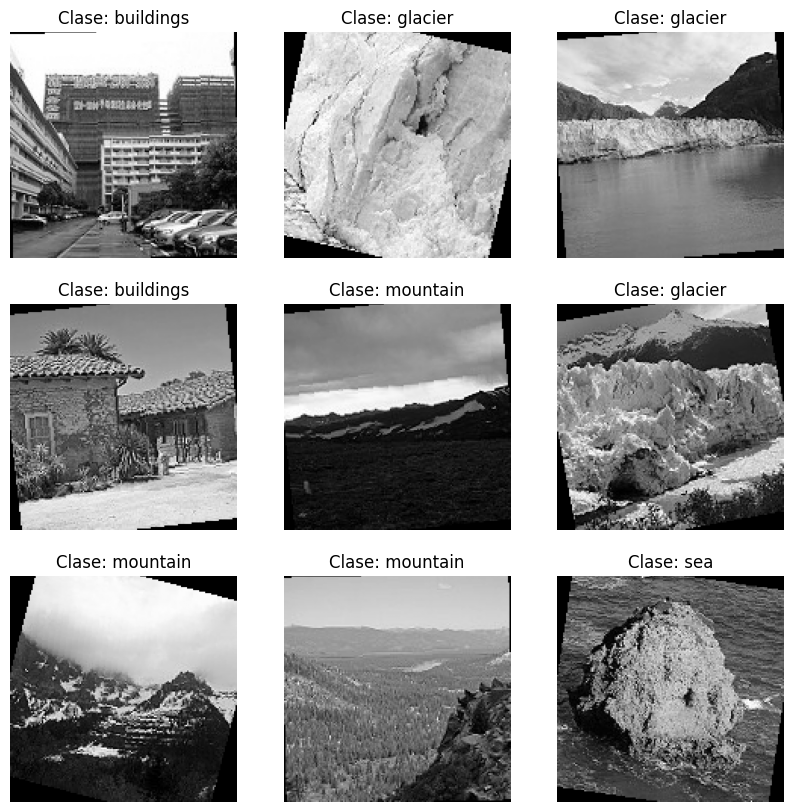

In [80]:
# Check some examples
for images, labels in train_loader:
    # Desnormalizar para visualización (0.5*2 + 0.5 = 1.0)
    images_plot = images * 0.5 + 0.5

    plt.figure(figsize=(10, 10))
    for i in range(9):  
        ax = plt.subplot(3, 3, i + 1)
        # Mostramos el canal 0 (gris)
        plt.imshow(images_plot[i][0], cmap='gray')  
        plt.title(f"Clase: {train_dataset.classes[labels[i].item()]}")
        plt.axis('off')
    plt.show()
    break

## Preparación de Datasets de Validación y Test con Muestreo Estratificado

En esta sección, cargamos el dataset de validación, aplicamos un muestreo estratificado para asegurar el equilibrio entre clases y creamos conjuntos separados de **validación** y **test**.

1. **Carga del Dataset Completo**:  
   Se utiliza el directorio local `data/seg_test` y se aplican las mismas transformaciones que en el entrenamiento. Los objetivos (targets) se convierten en un arreglo de NumPy para el proceso de estratificación.

2. **Muestreo Estratificado**:  
   Mediante `StratifiedShuffleSplit`, se garantiza que cada subconjunto mantenga la misma distribución de clases que el dataset original. Se generan dos muestras no solapadas: una para **validación** y otra para **prueba**.

3. **Asignación de Subconjuntos**:  
   - El primer subconjunto se asigna como **dataset de validación** (usado para ajustar hiperparámetros).  
   - El segundo subconjunto se asigna como **dataset de test** (usado para la evaluación final interna).

4. **DataLoaders**:  
   Se crean cargadores con un `batch_size` de `100` y `shuffle=False` para mantener la consistencia en el orden y la distribución estratificada durante la evaluación.

**Propósito**: Este enfoque evita sesgos de clase y asegura que la evaluación del modelo sea justa y representativa antes de realizar la inferencia en los datos de la competencia.

In [81]:
# Validation and test data local
val_path = os.path.join(base_path, 'seg_test')
val_dataset_full = datasets.ImageFolder(root=val_path, transform=test_transform)

targets = np.array(val_dataset_full.targets)  
sample_size = 100  # Tamaño de cada muestra

num_iterations = 2  
# Split estratificado para mantener la proporción de las 6 clases
splitter = StratifiedShuffleSplit(n_splits=num_iterations, test_size=sample_size, random_state=42)

sample_datasets = []
for _, sample_idx in splitter.split(np.zeros(len(targets)), targets):
    sample_datasets.append(Subset(val_dataset_full, sample_idx))

# Asignamos los subconjuntos
val_dataset = sample_datasets[0]
test_dataset = sample_datasets[1]

# DataLoaders para validación y test
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Dataset de validación: {len(val_dataset)} imágenes")
print(f"Dataset de prueba interno: {len(test_dataset)} imágenes")

Dataset de validación: 100 imágenes
Dataset de prueba interno: 100 imágenes


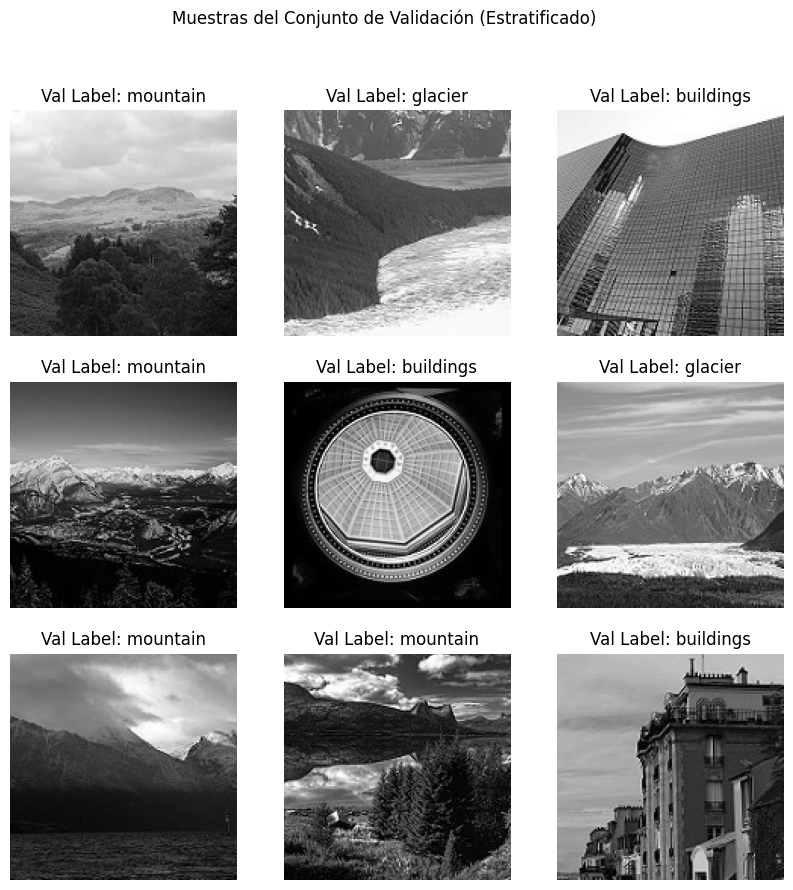

In [82]:
# Check some examples of the validation data
for images, labels in val_loader:
    # Desnormalizar las imágenes para la visualización
    images_val = images * 0.5 + 0.5

    # Graficar las imágenes
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Graficar 9 imágenes
        ax = plt.subplot(3, 3, i + 1)
        # Usamos images_val[i][0] para mostrar el único canal de gris
        plt.imshow(images_val[i][0], cmap='gray')  
        # Mostramos el nombre de la clase usando el índice de la etiqueta
        plt.title(f"Val Label: {train_dataset.classes[labels[i].item()]}")
        plt.axis('off')
    plt.suptitle("Muestras del Conjunto de Validación (Estratificado)")
    plt.show()
    break

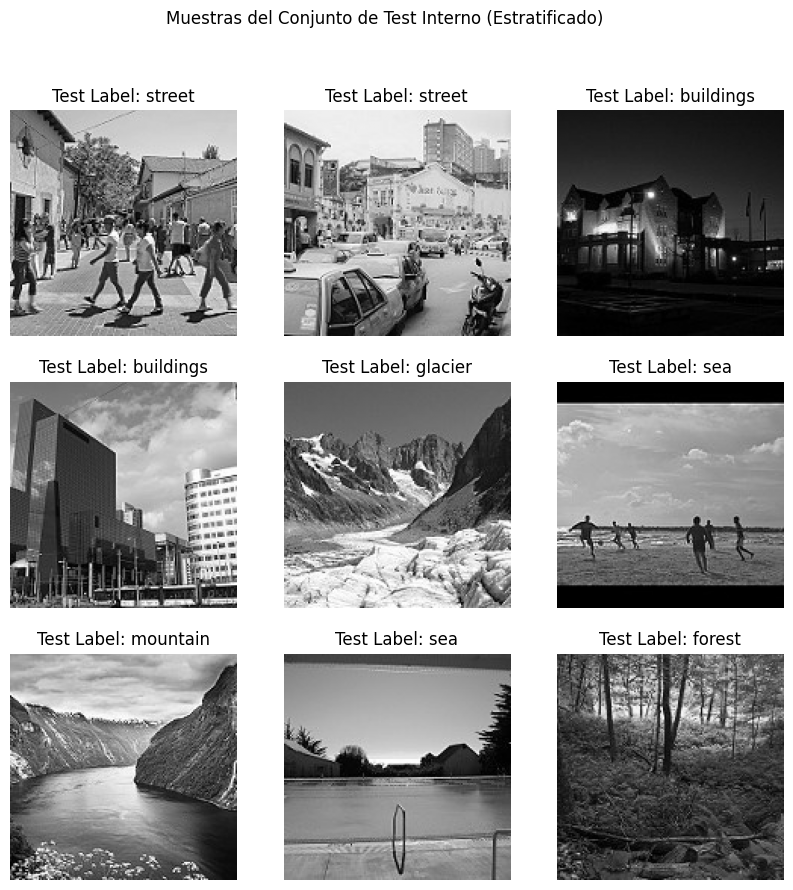

In [83]:
# Check some examples of the test data
for images, labels in test_loader:
    # Desnormalizar las imágenes para la visualización
    images_test = images * 0.5 + 0.5

    # Graficar las imágenes
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Graficar 9 imágenes
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images_test[i][0], cmap='gray')  
        plt.title(f"Test Label: {train_dataset.classes[labels[i].item()]}")
        plt.axis('off')
    plt.suptitle("Muestras del Conjunto de Test Interno (Estratificado)")
    plt.show()
    break

## Preparación del Dataset de Competencia (Prueba Ciega)

Esta sección crea el conjunto de datos para las imágenes de la competencia (`comp_test`), las cuales no tienen etiquetas. El objetivo es preparar estas imágenes para la inferencia y generar el archivo de predicciones finales.

1. **Listado de Archivos**:  
   Se accede al directorio local `data/seg_pred` y se filtran únicamente los archivos con extensiones válidas (`.png`, `.jpg`, `.jpeg`).

2. **Selección de Imágenes**:  
   Se selecciona un subconjunto de imágenes (por ejemplo, las primeras 200) para validar que el flujo de inferencia funciona correctamente antes de procesar el set completo.

3. **Dataset Personalizado (`SelectedFilesDataset`)**:  
   - Se implementó una clase que hereda de `Dataset` para manejar imágenes sin etiquetas.
   - **Conversión a Gris**: A diferencia del estándar RGB, las imágenes se convierten a escala de grises (`"L"`) para coincidir con el entrenamiento del modelo.
   - El método `__getitem__` devuelve tanto la imagen procesada como su **nombre de archivo**, lo cual es indispensable para el ID de la entrega final.

4. **DataLoader de Inferencia**:  
   Se configura con un `batch_size` adecuado y `shuffle=False` para asegurar que las predicciones mantengan el orden de los nombres de archivo.

Este proceso garantiza que los datos ciegos reciban exactamente el mismo tratamiento de preprocesamiento que los datos de entrenamiento.

In [84]:
# Paso 1: Listar imágenes en el directorio local
# CAMBIO: Usamos la ruta local 'data/seg_pred' definida anteriormente
image_directory = os.path.join('data', 'seg_pred') 
image_files = os.listdir(image_directory)

# Filtrar extensiones de imagen
image_files = [f for f in image_files if f.endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

# Paso 2: Seleccionar las primeras 200 imágenes (para prueba rápida)
image_files = image_files[:200]

class SelectedFilesDataset(Dataset):
    def __init__(self, root_dir, file_names, transform=None):
        self.root_dir = root_dir
        self.file_names = file_names
        self.transform = transform

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_path = os.path.join(self.root_dir, self.file_names[idx])
        
        # CAMBIO: .convert("L") en lugar de "RGB" porque la competencia exige escala de grises (1 canal)
        image = Image.open(file_path).convert("L")  

        if self.transform:
            image = self.transform(image)

        return image, self.file_names[idx] 

# Uso del dataset
# CAMBIO: Asegúrate de usar el 'transform' que definimos al principio (150x150, Gray, Normalize)
comp_test_dataset = SelectedFilesDataset(image_directory, image_files, transform=transform)

# CAMBIO: batch_size=32 para mantener consistencia con el entrenamiento, aunque 100 también funciona para inferencia
comp_test_loader = DataLoader(comp_test_dataset, batch_size=32, shuffle=False) 

# Verificación
for images, names in comp_test_loader:
    print(f"Batch de competencia: {images.shape}") # Debe ser [Batch, 1, 150, 150]
    print(f"Primer archivo: {names[0]}")
    break

Batch de competencia: torch.Size([32, 1, 150, 150])
Primer archivo: 10004.jpg


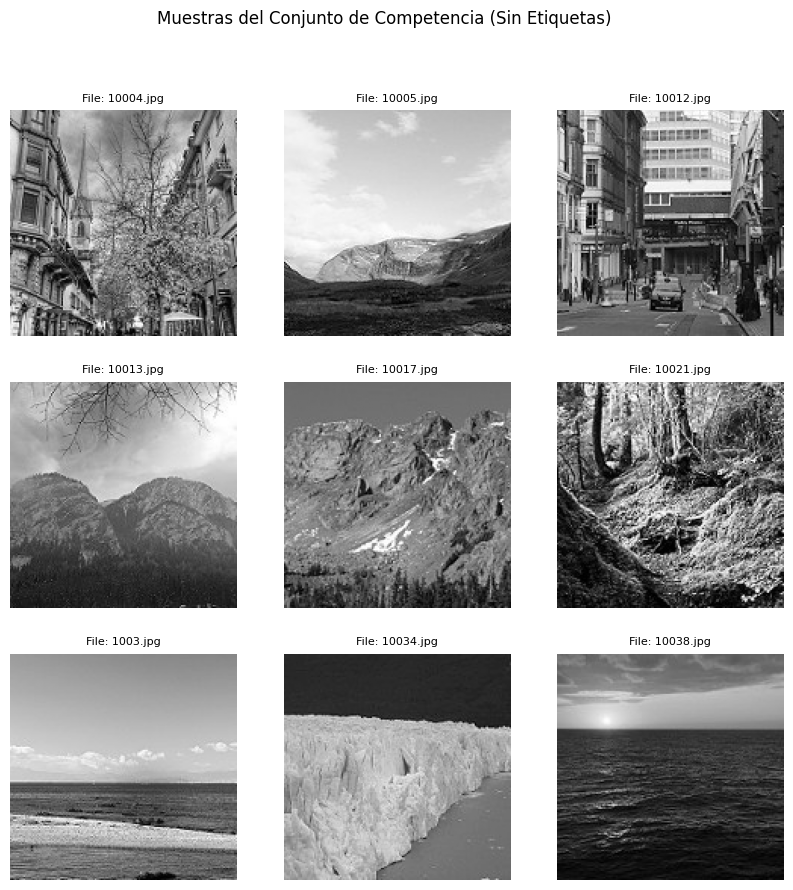

In [85]:
# Check some examples of the competition test data
for images, filenames in comp_test_loader:
    # Desnormalizar las imágenes para la visualización
    images_comp = images * 0.5 + 0.5

    # Graficar las imágenes
    plt.figure(figsize=(10, 10))
    for i in range(min(9, len(filenames))):  # Graficar hasta 9 imágenes
        ax = plt.subplot(3, 3, i + 1)
        # Mostramos el canal 0 (gris)
        plt.imshow(images_comp[i][0], cmap='gray')  
        
        # CAMBIO: Mostramos el nombre del archivo como título para verificar la carga
        plt.title(f"File: {filenames[i]}", fontsize=8)
        plt.axis('off')
    
    plt.suptitle("Muestras del Conjunto de Competencia (Sin Etiquetas)")
    plt.show()
    break

## Paso 2: Configuración del Entrenamiento del Modelo

Este paso se centra en definir la **arquitectura del modelo**, establecer la **función de pérdida**, el **optimizador** y crear el **bucle de entrenamiento**.

### Definición de la Arquitectura
Se utiliza una Red Neuronal Convolucional (CNN) diseñada para procesar imágenes en escala de grises de $150 \times 150$ píxeles. Esta arquitectura es ideal para capturar patrones espaciales en imágenes de paisajes y clasificarlas en las 6 categorías del dataset.

In [86]:
# Configuración del hardware
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Corriendo en: {device}")


input_size = 150 * 150  # El tamaño de la imagen aplanada
n_classes = 6           # Las 6 categorías de paisajes

model = nn.Sequential(
    nn.Flatten(),
    
    # Capa 1: Aumentamos a 1024 pero con Dropout fuerte
    nn.Linear(input_size, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(0.3), 
    
    # Capa 2
    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.4),
    
    # Capa 3
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.3),
    
    # Salida
    nn.Linear(256, n_classes)
)
model = model.to(device)
print(model) 


print("Modelo listo para el entrenamiento.")

Corriendo en: cuda
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=22500, out_features=1024, bias=True)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.3, inplace=False)
  (5): Linear(in_features=1024, out_features=512, bias=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.4, inplace=False)
  (9): Linear(in_features=512, out_features=256, bias=True)
  (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Dropout(p=0.3, inplace=False)
  (13): Linear(in_features=256, out_features=6, bias=True)
)
Modelo listo para el entrenamiento.


### **2. Define the Loss Function and Optimizer**
- The **loss function** (e.g., `CrossEntropyLoss`) measures how well the model's predictions match the true labels.
- The **optimizer** (e.g.,`SGD`) updates the model’s parameters to minimize the loss.

In [87]:
# Definir la función de pérdida y el optimizador
# Usamos CrossEntropyLoss porque tenemos 6 clases de paisajes
criterion = nn.CrossEntropyLoss()

# El weight_decay es como una dieta para los pesos del modelo
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Bajamos un poco el learning rate (de 0.001 a 0.0005) 
# porque las redes con BatchNorm entrenan mejor con pasos más pequeños.

# Número de épocas para el entrenamiento
epochs = 75

print("Configuración de pérdida y optimizador lista.")

Configuración de pérdida y optimizador lista.


### **3. Training Loop**
The model is trained iteratively using:
1. **Forward pass** – The model makes predictions.
2. **Loss computation** – The difference between predictions and actual labels is calculated.
3. **Backward pass** – Gradients are computed via backpropagation.
4. **Parameter update** – The optimizer updates model weights to minimize loss.
5. **Evaluation on the validation set** – The model’s performance is monitored to avoid overfitting.

In [88]:

def get_batch_accuracy(output, y, N):
    # Obtener la clase con mayor probabilidad
    pred = output.argmax(dim=1, keepdim=True) 
    # Comparar con la etiqueta real
    correct = pred.eq(y.view_as(pred)).sum().item()
    # Retornar proporción
    return correct / N

print(f"Iniciando entrenamiento en {device}...")

train_losses = []
train_accuracies = []
val_accuracies = []

print(f"Entrenando Perceptrón Multicapa en {device}...")

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    epoch_accuracy = 0
    
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        x, y = x.to(device), y.to(device)
        
        # Forward pass
        output = model(x)
        loss = criterion(output, y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        # Usamos la nueva función de accuracy
        epoch_accuracy += get_batch_accuracy(output, y, len(train_dataset))
        
    # Validación
    model.eval()
    val_accuracy = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            val_accuracy += get_batch_accuracy(output, y, len(val_dataset))
            
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    val_accuracies.append(val_accuracy)
    
    print(f"Train Accuracy: {epoch_accuracy:.4f} | Val Accuracy: {val_accuracy:.4f}")

print("¡Entrenamiento completado!")

Iniciando entrenamiento en cuda...
Entrenando Perceptrón Multicapa en cuda...


Epoch 1: 100%|██████████| 439/439 [00:19<00:00, 23.05it/s]


Train Accuracy: 0.4096 | Val Accuracy: 0.4900


Epoch 2: 100%|██████████| 439/439 [00:18<00:00, 23.81it/s]


Train Accuracy: 0.4480 | Val Accuracy: 0.5000


Epoch 3: 100%|██████████| 439/439 [00:18<00:00, 23.67it/s]


Train Accuracy: 0.4649 | Val Accuracy: 0.5300


Epoch 4: 100%|██████████| 439/439 [00:18<00:00, 23.77it/s]


Train Accuracy: 0.4743 | Val Accuracy: 0.5300


Epoch 5: 100%|██████████| 439/439 [00:18<00:00, 23.53it/s]


Train Accuracy: 0.4795 | Val Accuracy: 0.5300


Epoch 6: 100%|██████████| 439/439 [00:18<00:00, 23.65it/s]


Train Accuracy: 0.4896 | Val Accuracy: 0.5500


Epoch 7: 100%|██████████| 439/439 [00:18<00:00, 23.59it/s]


Train Accuracy: 0.4952 | Val Accuracy: 0.5800


Epoch 8: 100%|██████████| 439/439 [00:18<00:00, 23.51it/s]


Train Accuracy: 0.5038 | Val Accuracy: 0.5500


Epoch 9: 100%|██████████| 439/439 [00:18<00:00, 23.45it/s]


Train Accuracy: 0.5048 | Val Accuracy: 0.5500


Epoch 10: 100%|██████████| 439/439 [00:18<00:00, 23.49it/s]


Train Accuracy: 0.5067 | Val Accuracy: 0.5900


Epoch 11: 100%|██████████| 439/439 [00:18<00:00, 23.46it/s]


Train Accuracy: 0.5159 | Val Accuracy: 0.5500


Epoch 12: 100%|██████████| 439/439 [00:18<00:00, 23.40it/s]


Train Accuracy: 0.5202 | Val Accuracy: 0.5500


Epoch 13: 100%|██████████| 439/439 [00:19<00:00, 22.94it/s]


Train Accuracy: 0.5266 | Val Accuracy: 0.6100


Epoch 14: 100%|██████████| 439/439 [00:19<00:00, 22.02it/s]


Train Accuracy: 0.5268 | Val Accuracy: 0.5900


Epoch 15: 100%|██████████| 439/439 [00:19<00:00, 22.42it/s]


Train Accuracy: 0.5259 | Val Accuracy: 0.6000


Epoch 16: 100%|██████████| 439/439 [00:19<00:00, 22.71it/s]


Train Accuracy: 0.5362 | Val Accuracy: 0.5900


Epoch 17: 100%|██████████| 439/439 [00:19<00:00, 22.62it/s]


Train Accuracy: 0.5353 | Val Accuracy: 0.5900


Epoch 18: 100%|██████████| 439/439 [00:20<00:00, 21.57it/s]


Train Accuracy: 0.5356 | Val Accuracy: 0.5800


Epoch 19: 100%|██████████| 439/439 [00:19<00:00, 22.36it/s]


Train Accuracy: 0.5396 | Val Accuracy: 0.5900


Epoch 20: 100%|██████████| 439/439 [00:19<00:00, 22.41it/s]


Train Accuracy: 0.5436 | Val Accuracy: 0.5700


Epoch 21: 100%|██████████| 439/439 [00:19<00:00, 22.47it/s]


Train Accuracy: 0.5449 | Val Accuracy: 0.5800


Epoch 22: 100%|██████████| 439/439 [00:19<00:00, 22.57it/s]


Train Accuracy: 0.5457 | Val Accuracy: 0.5800


Epoch 23: 100%|██████████| 439/439 [00:19<00:00, 22.51it/s]


Train Accuracy: 0.5490 | Val Accuracy: 0.5500


Epoch 24: 100%|██████████| 439/439 [00:20<00:00, 21.39it/s]


Train Accuracy: 0.5501 | Val Accuracy: 0.6100


Epoch 25: 100%|██████████| 439/439 [00:21<00:00, 20.19it/s]


Train Accuracy: 0.5520 | Val Accuracy: 0.6200


Epoch 26: 100%|██████████| 439/439 [00:18<00:00, 23.61it/s]


Train Accuracy: 0.5552 | Val Accuracy: 0.6100


Epoch 27: 100%|██████████| 439/439 [00:18<00:00, 23.49it/s]


Train Accuracy: 0.5559 | Val Accuracy: 0.6100


Epoch 28: 100%|██████████| 439/439 [00:18<00:00, 23.46it/s]


Train Accuracy: 0.5603 | Val Accuracy: 0.5900


Epoch 29: 100%|██████████| 439/439 [00:18<00:00, 23.48it/s]


Train Accuracy: 0.5611 | Val Accuracy: 0.5800


Epoch 30: 100%|██████████| 439/439 [00:18<00:00, 23.55it/s]


Train Accuracy: 0.5602 | Val Accuracy: 0.5900


Epoch 31: 100%|██████████| 439/439 [00:18<00:00, 23.59it/s]


Train Accuracy: 0.5640 | Val Accuracy: 0.5800


Epoch 32: 100%|██████████| 439/439 [00:19<00:00, 23.07it/s]


Train Accuracy: 0.5585 | Val Accuracy: 0.5700


Epoch 33: 100%|██████████| 439/439 [00:18<00:00, 23.24it/s]


Train Accuracy: 0.5704 | Val Accuracy: 0.5800


Epoch 34: 100%|██████████| 439/439 [00:18<00:00, 23.36it/s]


Train Accuracy: 0.5709 | Val Accuracy: 0.5600


Epoch 35: 100%|██████████| 439/439 [00:18<00:00, 23.23it/s]


Train Accuracy: 0.5686 | Val Accuracy: 0.6000


Epoch 36: 100%|██████████| 439/439 [00:18<00:00, 23.54it/s]


Train Accuracy: 0.5692 | Val Accuracy: 0.6100


Epoch 37: 100%|██████████| 439/439 [00:19<00:00, 22.36it/s]


Train Accuracy: 0.5750 | Val Accuracy: 0.6500


Epoch 38: 100%|██████████| 439/439 [00:19<00:00, 22.21it/s]


Train Accuracy: 0.5730 | Val Accuracy: 0.6200


Epoch 39: 100%|██████████| 439/439 [00:19<00:00, 22.59it/s]


Train Accuracy: 0.5709 | Val Accuracy: 0.6100


Epoch 40: 100%|██████████| 439/439 [00:22<00:00, 19.73it/s]


Train Accuracy: 0.5789 | Val Accuracy: 0.5900


Epoch 41: 100%|██████████| 439/439 [00:19<00:00, 22.79it/s]


Train Accuracy: 0.5775 | Val Accuracy: 0.6000


Epoch 42: 100%|██████████| 439/439 [00:19<00:00, 22.69it/s]


Train Accuracy: 0.5753 | Val Accuracy: 0.6500


Epoch 43: 100%|██████████| 439/439 [00:19<00:00, 22.54it/s]


Train Accuracy: 0.5828 | Val Accuracy: 0.6200


Epoch 44: 100%|██████████| 439/439 [00:19<00:00, 22.65it/s]


Train Accuracy: 0.5802 | Val Accuracy: 0.6300


Epoch 45: 100%|██████████| 439/439 [00:19<00:00, 22.50it/s]


Train Accuracy: 0.5847 | Val Accuracy: 0.6300


Epoch 46: 100%|██████████| 439/439 [00:19<00:00, 22.59it/s]


Train Accuracy: 0.5795 | Val Accuracy: 0.6100


Epoch 47: 100%|██████████| 439/439 [00:19<00:00, 22.58it/s]


Train Accuracy: 0.5828 | Val Accuracy: 0.6100


Epoch 48: 100%|██████████| 439/439 [00:19<00:00, 22.64it/s]


Train Accuracy: 0.5938 | Val Accuracy: 0.6100


Epoch 49: 100%|██████████| 439/439 [00:19<00:00, 22.61it/s]


Train Accuracy: 0.5874 | Val Accuracy: 0.6100


Epoch 50: 100%|██████████| 439/439 [00:19<00:00, 22.51it/s]


Train Accuracy: 0.5865 | Val Accuracy: 0.6000


Epoch 51: 100%|██████████| 439/439 [00:19<00:00, 22.75it/s]


Train Accuracy: 0.5916 | Val Accuracy: 0.6400


Epoch 52: 100%|██████████| 439/439 [00:19<00:00, 22.38it/s]


Train Accuracy: 0.5923 | Val Accuracy: 0.5900


Epoch 53: 100%|██████████| 439/439 [00:19<00:00, 22.60it/s]


Train Accuracy: 0.5909 | Val Accuracy: 0.6100


Epoch 54: 100%|██████████| 439/439 [00:19<00:00, 22.50it/s]


Train Accuracy: 0.5990 | Val Accuracy: 0.6200


Epoch 55: 100%|██████████| 439/439 [00:20<00:00, 21.82it/s]


Train Accuracy: 0.5911 | Val Accuracy: 0.6600


Epoch 56: 100%|██████████| 439/439 [00:20<00:00, 21.50it/s]


Train Accuracy: 0.5955 | Val Accuracy: 0.6200


Epoch 57: 100%|██████████| 439/439 [00:20<00:00, 21.53it/s]


Train Accuracy: 0.5936 | Val Accuracy: 0.6100


Epoch 58: 100%|██████████| 439/439 [00:20<00:00, 21.86it/s]


Train Accuracy: 0.6005 | Val Accuracy: 0.6600


Epoch 59: 100%|██████████| 439/439 [00:18<00:00, 23.13it/s]


Train Accuracy: 0.5971 | Val Accuracy: 0.6300


Epoch 60: 100%|██████████| 439/439 [00:18<00:00, 23.29it/s]


Train Accuracy: 0.5967 | Val Accuracy: 0.6300


Epoch 61: 100%|██████████| 439/439 [00:18<00:00, 23.27it/s]


Train Accuracy: 0.6001 | Val Accuracy: 0.6200


Epoch 62: 100%|██████████| 439/439 [00:18<00:00, 23.16it/s]


Train Accuracy: 0.5962 | Val Accuracy: 0.6400


Epoch 63: 100%|██████████| 439/439 [00:19<00:00, 22.72it/s]


Train Accuracy: 0.5993 | Val Accuracy: 0.6600


Epoch 64: 100%|██████████| 439/439 [00:19<00:00, 22.65it/s]


Train Accuracy: 0.6073 | Val Accuracy: 0.6300


Epoch 65: 100%|██████████| 439/439 [00:19<00:00, 22.88it/s]


Train Accuracy: 0.6064 | Val Accuracy: 0.5800


Epoch 66: 100%|██████████| 439/439 [00:19<00:00, 21.96it/s]


Train Accuracy: 0.6027 | Val Accuracy: 0.5800


Epoch 67: 100%|██████████| 439/439 [00:19<00:00, 22.16it/s]


Train Accuracy: 0.6092 | Val Accuracy: 0.6500


Epoch 68: 100%|██████████| 439/439 [00:18<00:00, 23.43it/s]


Train Accuracy: 0.6052 | Val Accuracy: 0.6100


Epoch 69: 100%|██████████| 439/439 [00:18<00:00, 23.32it/s]


Train Accuracy: 0.6069 | Val Accuracy: 0.6400


Epoch 70: 100%|██████████| 439/439 [00:18<00:00, 23.28it/s]


Train Accuracy: 0.6062 | Val Accuracy: 0.6100


Epoch 71: 100%|██████████| 439/439 [00:20<00:00, 21.62it/s]


Train Accuracy: 0.6142 | Val Accuracy: 0.6300


Epoch 72: 100%|██████████| 439/439 [00:19<00:00, 22.17it/s]


Train Accuracy: 0.6092 | Val Accuracy: 0.6100


Epoch 73: 100%|██████████| 439/439 [00:19<00:00, 22.25it/s]


Train Accuracy: 0.6092 | Val Accuracy: 0.6500


Epoch 74: 100%|██████████| 439/439 [00:19<00:00, 22.50it/s]


Train Accuracy: 0.6109 | Val Accuracy: 0.6100


Epoch 75: 100%|██████████| 439/439 [00:19<00:00, 22.55it/s]

Train Accuracy: 0.6170 | Val Accuracy: 0.6700
¡Entrenamiento completado!


### **4. Model Evaluation on Test Set**

After training, the model's performance is assessed on the test dataset to evaluate its generalization to unseen data. This involves computing the loss and accuracy without updating model parameters, ensuring an unbiased estimate of its predictive capabilities.


In [93]:
# --- EVALUACIÓN EN EL TEST SET INTERNO (Estilo MLP) ---
model.eval()
test_accuracy = 0
test_loss = 0.0

print("Evaluando el modelo en el set de prueba interno...")

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        
        output = model(x)
        loss = criterion(output, y)
        test_loss += loss.item()
        
        # Usamos tu función get_batch_accuracy
        test_accuracy += get_batch_accuracy(output, y, len(test_dataset))

print(f"\nResultados en Test Set:")
print(f"Loss Total: {test_loss:.4f}")
print(f"Accuracy Final: {test_accuracy * 100:.2f}%")

Evaluando el modelo en el set de prueba interno...

Resultados en Test Set:
Loss Total: 3.9589
Accuracy Final: 64.00%


### **5. Generating Predictions for the Competition Test Set**

After training and validating the model, the next step is to generate predictions for the comp_test dataset, which contains unlabeled data. This involves processing the dataset through the trained model to obtain predicted labels. These predictions are then formatted according to the competition's submission requirements, a CSV file with each image's filename and its corresponding predicted label. This submission file is then uploaded to the competition platform for evaluation against the hidden ground-truth labels.


In [90]:
preds = []
ids = []

model.eval()

print("Generando predicciones para comp_test...")

with torch.no_grad():
    for images, names in tqdm(comp_test_loader):
        images = images.to(device)
        
        # El modelo ya tiene nn.Flatten(), así que procesa la imagen directo
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        preds.extend(predicted.cpu().numpy().tolist())
        ids.extend(list(names))

# Crear el CSV final
df_submission = pd.DataFrame({'id': ids, 'pred': preds})
df_submission.to_csv('predictions.csv', index=False)

print(f"Archivo 'predictions.csv' creado con {len(df_submission)} filas.")

Generando predicciones para comp_test...


100%|██████████| 7/7 [00:00<00:00, 38.43it/s]

Archivo 'predictions.csv' creado con 200 filas.


In [91]:
import pandas as pd

# ELIMINAMOS las líneas de sum(ids, []) y sum(preds, []) 
# porque las listas ya están aplanadas gracias al .extend() que usamos antes.

# Verificación de seguridad
if len(ids) != len(preds):
    raise ValueError(f"Error: Tenemos {len(ids)} IDs pero {len(preds)} predicciones. Deben coincidir.")

# Crear el DataFrame
df = pd.DataFrame({
    'id': ids,
    'pred': preds
})

# Guardar el archivo
csv_file = 'predictions.csv'
df.to_csv(csv_file, index=False)

print(f"¡Logrado! El archivo '{csv_file}' se creó correctamente con {len(df)} filas.")
# Mostramos un adelanto para estar seguros
print(df.head())

¡Logrado! El archivo 'predictions.csv' se creó correctamente con 200 filas.
          id  pred
0  10004.jpg     1
1  10005.jpg     3
2  10012.jpg     1
3  10013.jpg     3
4  10017.jpg     4


The file can be downloaded from the folder /kaggle/working